In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            # 'epochs_per_task': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:5' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.001,
            'metric' : "EO",
            'lambda': 0.1,
            'lambda_old': 0.0,

            # postprocessing
            # "post_processing": "eps_fairness"

              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=0_epoch=15_lr=0.001_tau=10.0_alpha=0.001_lmbd_0.1_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [5]:
# target_label = 0
# incremental_step = 1
# # cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
# cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
# to_pil_image(unnormalize(cat_img), mode="RGB")

In [6]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
# from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer
from trainers.baselines import BaseContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])
# 
trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [7]:
from algorithms.optimization import absolute_and_nonabsolute_minsum_LP_solver
solver = absolute_and_nonabsolute_minsum_LP_solver
converter = algorithm.converter_LP_absolute_additional_EO_v2

params['solver'] = solver
params['converter'] = converter

In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8271127393688753, 'loss': 0.002176862856456856, 'std': 0.04737705654949209, 'EER': -1, 'EO': [0.4595588235294118, 0.25], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6452205882352942, 'classwise_accuracy': {1: array([ 885, 1135]), 0: array([857, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 591, 0: 488}, 'class_pred_count_s1': {1: 417, 0: 619}, 'class_pred_count': {1: 1008, 0: 1107}, 'count_s0': 1079, 'count_s1': 1036, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9061584105007642, 'loss': 0.0011422632222479962, 'std': 0.016290569091072515, 'EER': -1, 'EO': [0.1544715447154471, 0.22977941176470584], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8078745217599235, 'classwise_accuracy': {0: array([904, 980]), 1: array([1010, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 488, 1: 591}, 'class_pred_count_s1': {1: 495, 0: 541}, 'class_pred_count': {0: 1

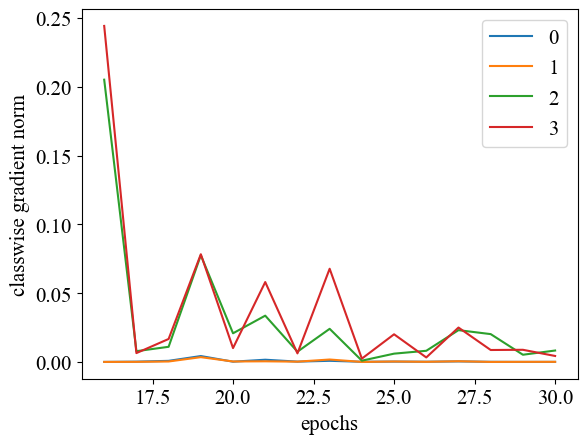

---------------------------- Task 3 -----------------------
loss_group=tensor([[2.4449e-04, 5.4900e-04, 4.9960e-01, 2.2193e-01, 9.4868e+00, 1.0546e+01,
         2.2613e-03, 8.6208e-04, 1.2397e+00, 4.8547e-01, 1.0277e+01, 1.1439e+01]])
Elapsed time(grad):4.973
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.307
Fairness:[ 0.         -0.01442027  0.17691827  0.18867653  0.          0.        ]
len(updated_seq_indices)=10880
Elapsed time(etc):0.396
[31] Eval metrics for task 1 >> {'accuracy': 0.9444844016901914, 'loss': 0.000824561010579409, 'std': 0.022035422098354795, 'EER': -1, 'EO': [0.0627923758335821, 0.09324603491936567], 'DP': -1, 'accuracy_s0': 0.982939100163657, 'accuracy_s1': 0.9049198947871832, 'classwise_accuracy': {1: array([1097, 1135]), 0: array([904, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 589, 0: 473, 5: 13, 2: 1, 4: 1, 3: 2}, 'class_pred_count_s1': {1: 509, 0: 431, 4: 19, 3: 31, 5: 21, 2: 25}, 'class_pred_count': {1: 1098, 0:

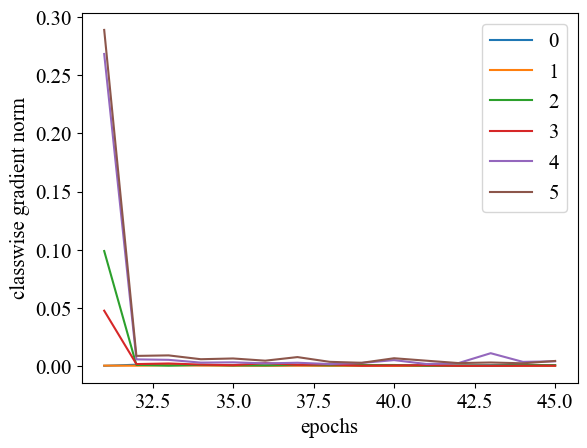

---------------------------- Task 4 -----------------------
loss_group=tensor([[3.2637e-04, 7.6834e-05, 1.8775e-03, 5.3875e-04, 9.3717e-04, 6.1993e-03,
         1.2930e+01, 8.1392e+00, 2.2535e-03, 3.8286e-03, 3.0163e-03, 5.0688e-03,
         1.3562e-01, 6.8220e-01, 1.3702e+01, 1.2792e+01]])
Elapsed time(grad):7.073
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):15.893
Fairness:[0.01079262 0.03918387 0.01839684 0.00846988 0.05990646 0.06827239
 0.         0.        ]
len(updated_seq_indices)=12183
Elapsed time(etc):0.339
[46] Eval metrics for task 1 >> {'accuracy': 0.9038613683358806, 'loss': 0.0015976530510764878, 'std': 0.004301896970241859, 'EER': -1, 'EO': [0.20249825818652334, 0.076802612288418], 'DP': -1, 'accuracy_s0': 0.9716686083603783, 'accuracy_s1': 0.8320181731229077, 'classwise_accuracy': {1: array([1021, 1135]), 0: array([890, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 589, 0: 462, 5: 22, 4: 1, 3: 3, 7: 1, 6: 1}, 'class_pred_count_s1

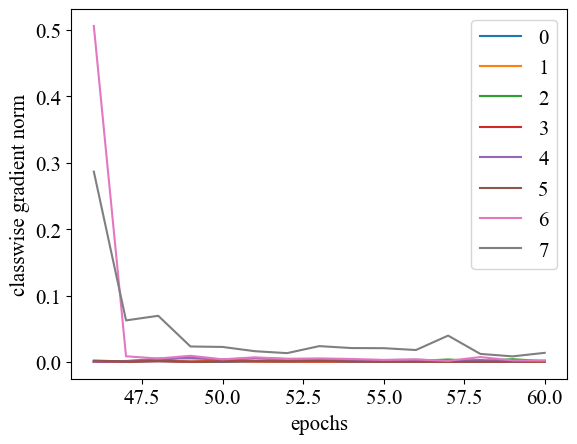

---------------------------- Task 5 -----------------------
loss_group=tensor([[9.2103e-04, 1.4779e-04, 8.2705e-03, 9.3591e-04, 5.1219e-03, 1.5399e-03,
         1.7658e-03, 7.0921e-02, 1.2790e+01, 1.7769e+01, 3.9409e-02, 4.5013e-03,
         8.3750e-03, 3.9619e-03, 2.0773e-02, 6.4505e-03, 5.0817e-01, 1.4002e-01,
         1.4272e+01, 1.5607e+01]])
Elapsed time(grad):6.682
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):18.148
Fairness:[-0.01207896 -0.00844009  0.0014397  -0.00014125 -0.00066015  0.02210003
  0.02673357  0.01571011  0.          0.        ]
len(updated_seq_indices)=11800
Elapsed time(etc):0.328
[61] Eval metrics for task 1 >> {'accuracy': 0.8899892115436483, 'loss': 0.002127425242259429, 'std': 0.04305043603344416, 'EER': -1, 'EO': [0.1905904304944689, 0.11146362098138751], 'DP': -1, 'accuracy_s0': 0.9645432859005298, 'accuracy_s1': 0.8135162601626016, 'classwise_accuracy': {0: array([830, 980]), 1: array([1059, 1135])}, 'DP_ingredients': {'cla

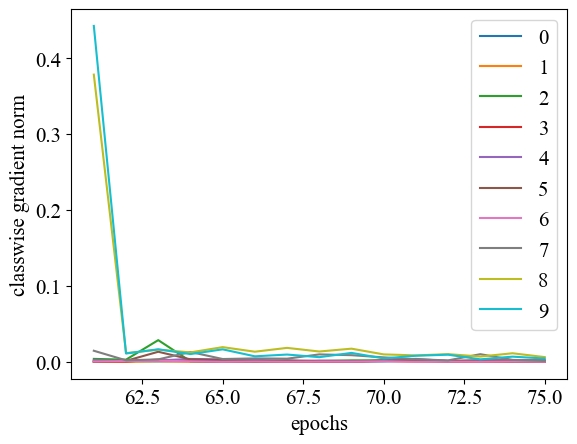

final avg-acc 0.8371795779462285
final avg-forget 0.0946858210819663


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3
task:4
task:5


In [12]:
binned_weight

{2: [{0: {1.0: 11521}, 1: {1.0: 568}},
  {0: {0.05: 8870, 0.35: 1, 0.9: 1, 1.0: 2649}, 1: {0.05: 40, 1.0: 528}},
  {0: {0.05: 11465, 0.5: 1, 1.0: 55}, 1: {0.05: 226, 1.0: 342}},
  {0: {0.05: 7670, 0.7: 1, 1.0: 3850}, 1: {0.05: 291, 1.0: 277}},
  {0: {0.05: 11101, 0.95: 1, 1.0: 419}, 1: {0.05: 249, 1.0: 319}},
  {0: {0.05: 5191, 0.95: 1, 1.0: 6329}, 1: {0.05: 329, 1.0: 239}},
  {0: {0.05: 11272, 1.0: 249}, 1: {0.05: 214, 0.6: 1, 1.0: 353}},
  {0: {0.05: 5606, 0.2: 1, 0.3: 1, 0.7: 1, 1.0: 5912},
   1: {0.05: 293, 1.0: 275}},
  {0: {0.05: 10200, 0.65: 1, 0.9: 1, 1.0: 1319}, 1: {0.05: 232, 1.0: 336}},
  {0: {0.05: 7570, 0.9: 1, 1.0: 3950}, 1: {0.05: 268, 1.0: 300}},
  {0: {0.05: 11281, 0.25: 1, 1.0: 239}, 1: {0.05: 191, 0.45: 1, 1.0: 376}},
  {0: {0.05: 8077, 0.3: 1, 0.35: 1, 1.0: 3442}, 1: {0.05: 278, 1.0: 290}},
  {0: {0.05: 3965, 0.45: 1, 0.8: 2, 1.0: 7553}, 1: {0.05: 244, 1.0: 324}},
  {0: {0.05: 7047, 0.25: 1, 0.7: 1, 1.0: 4472}, 1: {0.05: 274, 1.0: 294}},
  {0: {0.05: 10837, 0.3: 1, 

In [13]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.997, 0.   , 0.   , 0.   , 0.   ],
       [0.962, 0.84 , 0.   , 0.   , 0.   ],
       [0.932, 0.87 , 0.884, 0.   , 0.   ],
       [0.886, 0.814, 0.835, 0.927, 0.   ],
       [0.869, 0.781, 0.759, 0.889, 0.887]])

In [14]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.8990343463602075

In [15]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.007, 0.111, 0.168, 0.172, 0.221]

In [16]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.1358745129711394

In [17]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.011, 0.011, 0.009, 0.009, 0.009]

In [18]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.00989416786743747

In [19]:
task_id = 2

print(f"{task_id=}")
print(f"sensitive samples / all samples = {(benchmark.trains[task_id].sensitives != benchmark.trains[task_id].targets).sum().item()} / {benchmark.trains[task_id].sensitives.shape[0]}")

updated_seq_indices = benchmark.seq_indices_train[task_id]
print(f"sensitive samples / selected samples = {(benchmark.trains[task_id].sensitives[updated_seq_indices] != benchmark.trains[task_id].targets[updated_seq_indices]).sum().item()} / {len(updated_seq_indices)}")


task_id=2
sensitive samples / all samples = 568 / 12089
sensitive samples / selected samples = 568 / 12089


In [20]:
step_class = 2
for i in range(2, 6):
    incremental_step = i
    print(f"{incremental_step=}")
    one_idx = benchmark.trains[incremental_step].sample_weight > 0.9

    print(f"{2*i-2} : {(benchmark.trains[incremental_step].targets == (2*i-2)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-2)).sum().item()}")
    print(f"{2*i-1} : {(benchmark.trains[incremental_step].targets == (2*i-1)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-1)).sum().item()}")


incremental_step=2
2 : 5958 --> 575
3 : 6131 --> 441
incremental_step=3
4 : 5842 --> 788
5 : 5421 --> 997
incremental_step=4
6 : 5918 --> 307
7 : 6265 --> 230
incremental_step=5
8 : 5851 --> 1056
9 : 5949 --> 1339


In [21]:
metric_manager_callback.meters['classwise_accuracy'].get_data()

[{0: array([976, 980]), 1: array([1132, 1135])},
 {0: array([915, 980]),
  1: array([1124, 1135]),
  2: array([ 794, 1032]),
  3: array([ 919, 1010])},
 {1: array([1085, 1135]),
  0: array([889, 980]),
  2: array([ 886, 1032]),
  3: array([ 890, 1010]),
  5: array([717, 892]),
  4: array([946, 982])},
 {0: array([810, 980]),
  1: array([1072, 1135]),
  3: array([ 820, 1010]),
  2: array([ 842, 1032]),
  4: array([838, 982]),
  5: array([729, 892]),
  6: array([888, 958]),
  7: array([ 954, 1028])},
 {1: array([1041, 1135]),
  0: array([805, 980]),
  2: array([ 844, 1032]),
  3: array([ 752, 1010]),
  5: array([672, 892]),
  4: array([751, 982]),
  6: array([866, 958]),
  7: array([ 899, 1028]),
  9: array([ 863, 1009]),
  8: array([895, 974])}]